
## Applied Data Analysis Project
**Team**: ToeStewBrr - Alexander Sternfeld, Marguerite Thery, Antoine Bonnet, Hugo Bordereaux

**Dataset**: CMU Movie Summary Corpus

# Part 3: Textual Analysis

In this notebook, we analyze the pre-processed output of our custom CoreNLP pipeline. 

### Table of contents
1. [Loading pre-processed coreNLP data](#section1)
2. [Persona clusters](#section2)
    - 2.1. [Embedding descriptions](#section2-1)
    - 2.2. [Principal Component Analysis (PCA)](#section2-2)
    - 2.3. [Clustering personas](#section2-3)
    - 2.4. [Visualizing persona clusters](#section2-4)

**Prerequisite**: 

Install [spaCy](https://spacy.io) using the following commands: 

        pip install spacy
        
        python3 -m spacy download en_core_web_sm

In [1]:
import os
import pickle
import spacy
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from ast import literal_eval


from extraction import *
from coreNLP_analysis import *
from load_data import *
from textual_analysis import *


# NOTE: If you haven't loaded NLTK before, set this to True
load_nltk = False

if load_nltk: #Load the spaCy model for the semantic analysis
    nlp_spacy = spacy.load("en_core_web_lg")

pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abonnet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/abonnet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Load pre-processed coreNLP data <a class="anchor" id="section1"></a>

We first load the pre-processed output from our custom CoreNLP pipeline. 

In [2]:
char_description_path = 'Data/CoreNLP/char_descriptions.csv'
full_description_path = 'Data/CoreNLP/full_descriptions.csv'

# Load character descriptions
char_description_df = pd.read_csv(char_description_path, sep='\t', index_col=None, low_memory=False)

# Convert to lists
char_description_df['agent_verbs'] = char_description_df.agent_verbs.apply(
    lambda x: literal_eval(x) if type(x) == str else x)
char_description_df['patient_verbs'] = char_description_df.patient_verbs.apply(
    lambda x: literal_eval(x) if type(x) == str else x)
char_description_df['attributes'] = char_description_df.attributes.apply(
    lambda x: literal_eval(x) if type(x) == str else x)
char_description_df['descriptions'] = char_description_df.descriptions.apply(
    lambda x: literal_eval(x) if type(x) == str else x)
char_description_df['title'] = char_description_df.title.apply(
    lambda x: literal_eval(x) if type(x) == str else x)

full_description_df = pd.read_csv(full_description_path, sep='\t', index_col=None, low_memory=False)

## 2. Persona clusters <a class="anchor" id="section2"></a>

### 2.1. Embedding descriptions <a class="anchor" id="section2-1"></a>

We embed all descriptive words (actions, attributes, titles) of all characters into a high-dimensional vector space using spaCy. 

In [3]:
embedding_file = 'Data/CoreNLP/char_description_embeddings.pickle'

# If we have already embedded the descriptions, load them from the pickle file, else execute code below
if os.path.exists(embedding_file):
    char_description_df = pd.read_pickle(embedding_file)

else:
    # Embed descriptions (Get a comfy chair, this takes a while) 
    char_description_df = construct_descriptions_embeddings(char_description_df, nlp_spacy)
    # Save the embeddings to a pickle file
    with open(embedding_file, 'wb') as f:
        pickle.dump(char_description_df, f)

# Split embeddings by category
char_description_df = embeddings_categorical(char_description_df)

# FOR NEWCOMERS: PLEASE UPDATE THE CHAR DESCRIPTION FILE WITH THIS TO SKIP 1 MINUTE OF COMPUTATIONS

# Update pickle file
#with open(embedding_file, 'wb') as f:
#    pickle.dump(char_description_df, f)

### 2.2. Weighted average of word vectors <a class="anchor" id="section2-2"></a>

We then weigh the word embedding of each word for each character by their cosine distance to the average semantic vector of words with the sam type used for all characters in the dataset. The *cosine distance* is defined as:

$$\text{cosine distance}(x_1, x_2) = 1-\frac{x_1 \cdot x_2}{||x_1||\cdot||x_2||}$$

where $x_1$ and $x_2$ are the vector representations of two words.

Ideas for improvement: 
- [X] Add a threshold for the cosine difference to filter out words that are too close to the average vector. 
- [X] Compare each word to the average vector in their category rather than all words. 
- [X] Weigh each word using the word frequency as well.
- [X] Add percentile to word weighing to keep top p% of words with highest cos-diff
- [X] Give more importance to title than other words, (i.e. set title_weight to 0.5)
- [X] Weight all descriptions by weighing each column separately then concatenating. See point 2. Give more weight to title at the end. 
- [ ] Remove characters with < X mentions in plot summary using most_mentioned() function.

Note: calling weight_embeddings() with column='descriptions' weights all other columns by default. 

In [4]:
weight_df = weight_embeddings(char_description_df, column='descriptions', percentile=50)

## Experimenting with clustering methods

Now that we have weighted each word's embedding, we will try to look for good clustering parameters.

### 1. Clustering titles only

/Users/abonnet/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Number of clusters: 42
Number of noise points: 4955


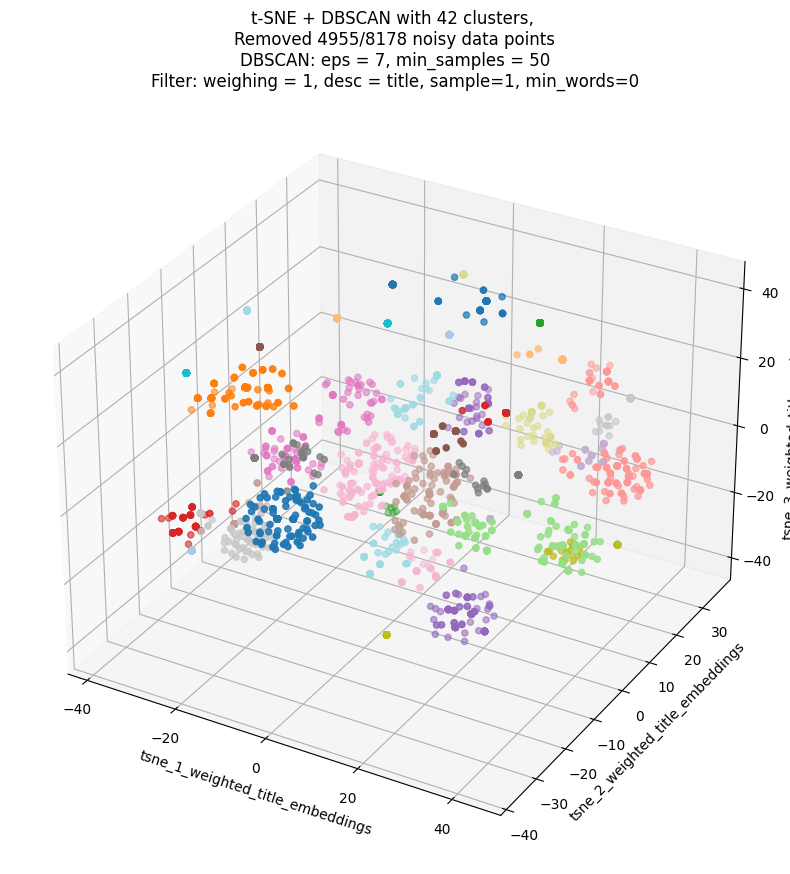

In [5]:
cluster1 = cluster_embeddings(weight_df, weighing=1, desc='title', sample=1, min_words=0, eps=7, min_samples=50)

/Users/abonnet/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Number of clusters: 66
Number of noise points: 2354


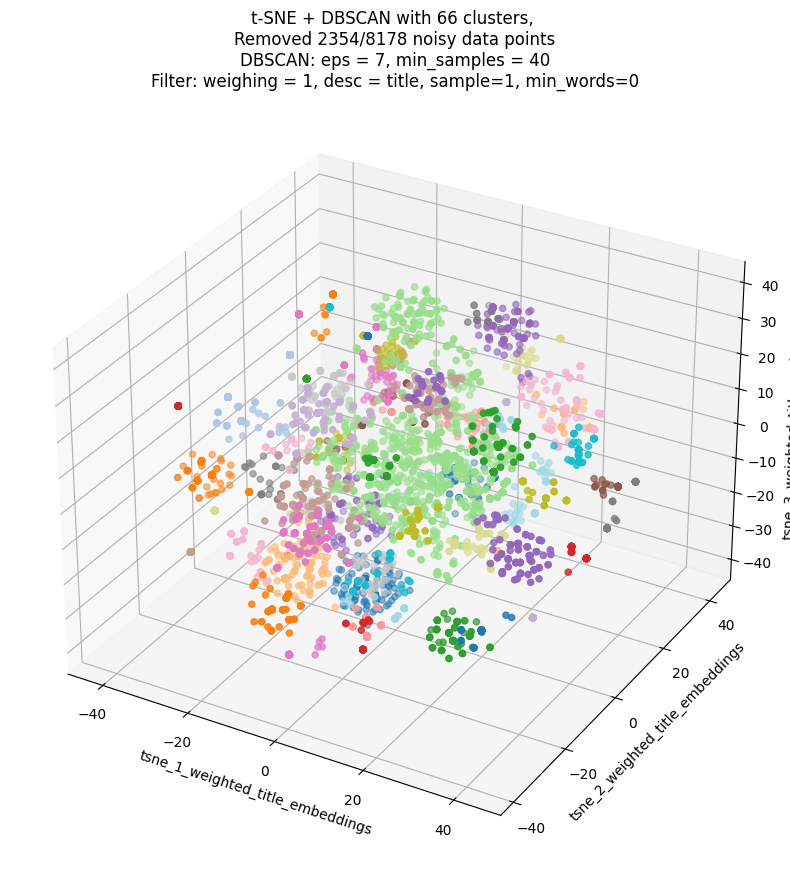

In [8]:
cluster2 = cluster_embeddings(weight_df, weighing=1, desc='title', sample=1, min_words=0, eps=7, min_samples=40)

### 2. Clustering descriptions 

/Users/abonnet/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


ValueError: Axis limits cannot be NaN or Inf

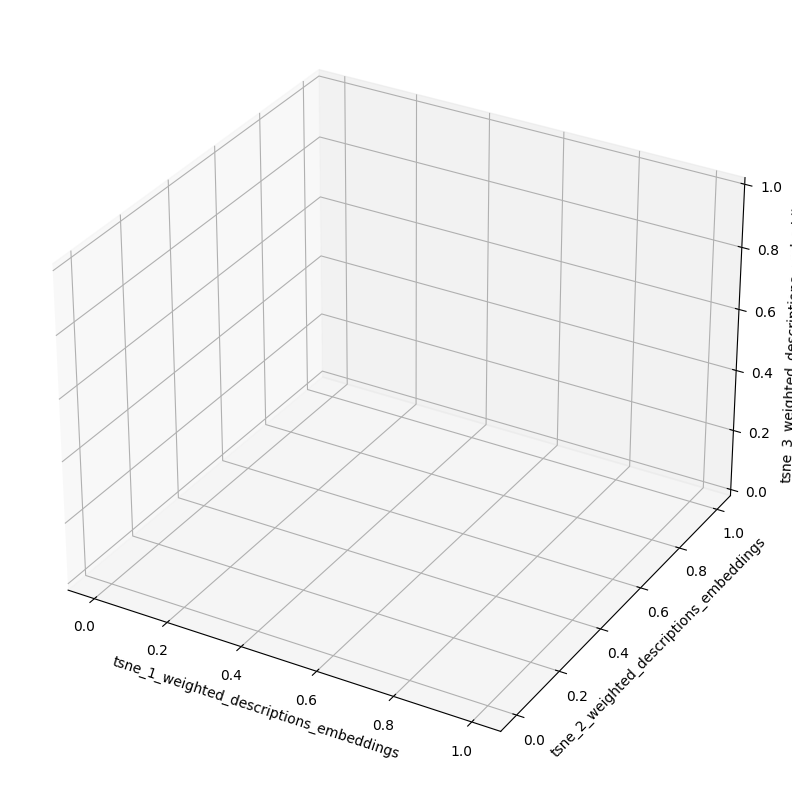

In [7]:
cluster4 = cluster_embeddings(weight_df, weighing=1, desc='descriptions', sample=0.01, min_words=0, eps=7, min_samples=50)

TODO: Find the best combination of (desc, sample, min_words, eps, min_samples) parameters for cluster_embeddings() + best percentile parameter for weight_embeddings() to have good clusters without removing too many points, and having 20-50 clusters of characters. 

In [39]:
desc = 'descriptions'
embed_type = desc + '_embeddings'
column = 'weighted_' + embed_type
weighing = 1
min_words = 0

df = weight_df.copy(deep=True)

### 2.3. Dimensionality reduction <a class="anchor" id="section2-3"></a>

#### 2.3.1. Principal Component Analysis (PCA) <a class="anchor" id="section2-3-1"></a>

To visualize our clusters, we then map these high-dimensional descriptive vectors to 50-dimensional space using PCA to prepare the ground for a second dimensionality reduction technique. 

In [40]:
# Dimensionality reduction: PCA to 50 dimensions -> t-SNE to 3 dimensions
sample = 0.1

if sample < 1: 
    df = df.sample(frac=sample, random_state=1)

In [41]:
n_total = df[column].apply(lambda x: 1 if type(x) == np.ndarray else 0).sum()
pca_df = descriptions_PCA(df, column=column, n_components=50)

#### 2.3.2. *t*-distributed Stochastic Neighbor Embedding (t-SNE) <a class="anchor" id="section2-3-2"></a>

We now perform [t-SNE dimensionality reduction](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) on the pre-reduced weighted embeddings. 

In [48]:
tsne_df = descriptions_tSNE(pca_df, column=column, n_components=3, learning_rate='auto')

/Users/abonnet/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [49]:
tsne_df

,Character name,Freebase character ID,agent_verbs,patient_verbs,attributes,title,descriptions,descriptions_embeddings,attributes_embeddings,title_embeddings,agent_verbs_embeddings,patient_verbs_embeddings,weighted_agent_verbs_embeddings,weighted_patient_verbs_embeddings,weighted_attributes_embeddings,weighted_title_embeddings,weighted_descriptions_embeddings,tsne_1_weighted_descriptions_embeddings,tsne_2_weighted_descriptions_embeddings,tsne_3_weighted_descriptions_embeddings
26010,Cole Thornton,/m/0gyfs31,"[depart, quit, look, chase, commit, come, shoo...","[walk, help, return, hire, trade]","[love, gunslinger, friend, presence, friend, o...",NaN,"[depart, quit, look, chase, commit, come, shoo...","{'depart': [[-2.9599, 1.3144, 2.8377, -1.3433,...","{'love': [[2.0565, -3.2259, -5.7364, -6.146, 0...",NaN,"{'depart': [[-2.9599, 1.3144, 2.8377, -1.3433,...","{'walk': [[0.75411, 3.9097, -4.065, -5.7688, -...","[-1.625185001641512, 1.5609469190239906, -0.71...","[-2.029275208711624, 0.37408703565597534, -2.3...","[0.17395395040512085, 0.3556663542985916, -1.6...",NaN,"[-2.1889646654586494, -0.4281607121122662, -3....",-17.949295,4.057569,7.953626
20519,Hedy,/m/0c1gp8z,NaN,NaN,NaN,[secretary],[secretary],"{'secretary': [[1.0731, -1.4094, -1.7041, -1.0...",NaN,"{'secretary': [[1.0731, -1.4094, -1.7041, -1.0...",NaN,NaN,NaN,NaN,NaN,"[1.073099970817566, -1.4093999862670898, -1.70...","[7.549439024302676, -7.977096989097241, 5.2638...",-43.017818,6.906512,13.540520
9053,Ricky Verona,/m/09rgzwj,"[try, kill, break, promise, use, inject, concl...","[leave, conclude, fall, find]","[brother, brother, helicopter, helicopter, thu...",NaN,"[try, kill, break, promise, use, inject, concl...","{'try': [[7.217, 4.5229, -6.6599, -0.3417, 1.1...","{'brother': [[-1.6475, -2.1285, -4.0365, 0.187...",NaN,"{'try': [[7.217, 4.5229, -6.6599, -0.3417, 1.1...","{'leave': [[2.2953, 4.0228, -2.7496, -0.77861,...","[-0.7246237527579069, -0.39592484245076776, 0....","[-1.143543004989624, -0.9639761298894882, -0.1...","[0.029635846614837646, 1.1140793859958649, -0....",NaN,"[-2.803362145101579, -2.7973985395907826, -1.9...",-3.512970,-14.101066,17.917194
23326,Viola,/m/0h2l6x2,"[get, take]",NaN,NaN,NaN,"[get, take]","{'get': [[0.069542, 2.3818, -3.2687, 1.2434, -...",NaN,NaN,"{'get': [[0.069542, 2.3818, -3.2687, 1.2434, -...",NaN,"[2.2553060054779053, -0.4962744116783142, -3.4...",NaN,NaN,NaN,"[-6.561236144422816, 4.854975830504243, 1.3156...",8.617455,14.133140,41.636162
12893,Rajiv Mathur,/m/0h75gwy,"[come, stand, end, realize, come, love, manage...","[see, smite, take, hug, end, woo, kid]","[happy, friend, drink, lot, lot, unable, one]",NaN,"[come, stand, end, realize, come, love, manage...","{'come': [[0.40645, 3.1869, -3.3483, 3.4634, -...","{'happy': [[1.0727, 0.91195, -4.1039, -5.9668,...",NaN,"{'come': [[0.40645, 3.1869, -3.3483, 3.4634, -...","{'see': [[3.359, 3.0831, 0.5473, -1.3214, -2.4...","[0.8446048051118851, 1.5583311021327972, -1.47...","[0.9535574316978455, 1.0257668793201447, -0.65...","[1.0320479795336723, -0.6418656408786774, -2.2...",NaN,"[-0.44693807413892844, 1.6590805349764708, -4....",15.840416,3.293866,3.363923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25484,Gordon,/m/0h5s9f_,"[suggest, find, try]",[raise],NaN,NaN,"[suggest, find, try, raise]","{'suggest': [[0.44733, -0.25177, 1.0902, 1.373...",NaN,NaN,"{'suggest': [[0.44733, -0.25177, 1.0902, 1.373...","{'raise': [[-2.6328, -0.26221, -6.5957, -0.373...","[2.9403621405363083, 1.6398218050599098, -2.14...","[-2.6328001022338867, -0.26221001148223877, -6...",NaN,NaN,"[-6.79040453286116, 4.404329682052895, 2.68972...",12.627019,18.802191,-17.049063
12664,Gringo Toad,/m/0g4zd03,"[sing, kidnap, declare, kidnap]",NaN,[mother],NaN,"[sing, kidnap, declare, kidnap, mother]","{'sing': [[1.5708, 0.80267, -1.468, -4.2981, 0...","{'mother': [[1.4643, -1.3328, -4.519, -1.814, ...",NaN,"{'sing': [[1.5708, 0.80267, -1.468, -4.2981, 0...",NaN,"[-1.1575357019901

In [ ]:
# Save the embeddings to a pickle file
#pickle_file = 'Data/CoreNLP/char_description_embeddings_tsne.pickle'
#with open(pickle_file, 'wb') as f:
#    pickle.dump(char_description_df, f)

KeyboardInterrupt: 

### 2.4. Clustering personas <a class="anchor" id="section2-4"></a>

The persona point cloud is clustered into several categories using DBSCAN. 

In [50]:
eps = 7
min_samples = 50

cluster_df, n_clusters, n_removed = DBSCAN_cluster(tsne_df, column, method='tsne', eps=eps, min_samples=min_samples)

In [52]:
# Why isn't the clustering working???

### 2.5. Visualizing persona clusters <a class="anchor" id="section2-5"></a>

The clustered persona point cloud is shown below. 

ValueError: Axis limits cannot be NaN or Inf

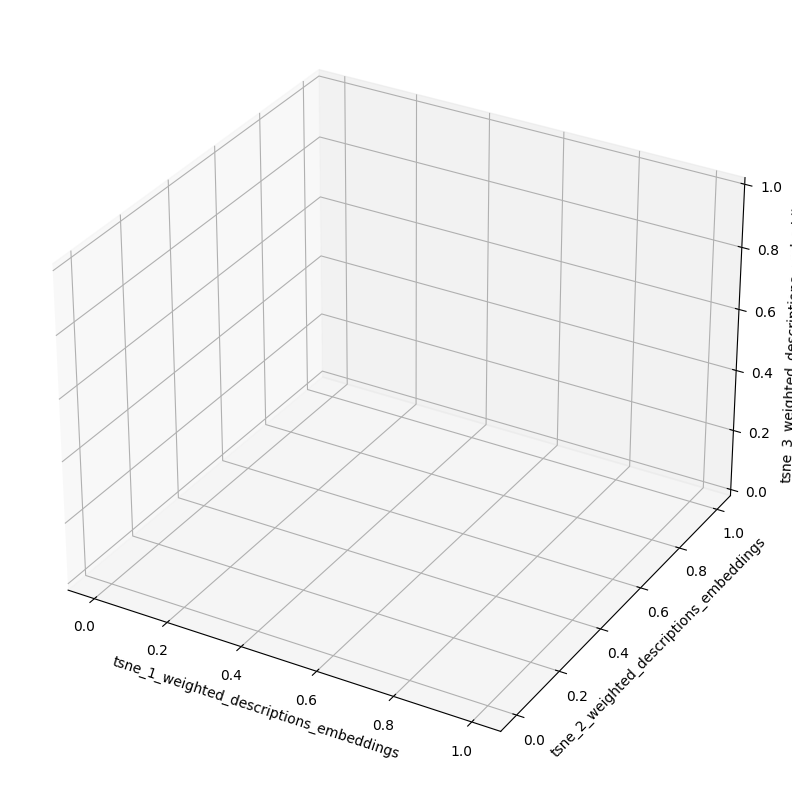

In [44]:
title = 't-SNE + DBSCAN with {} clusters, \nRemoved {}/{} noisy data points\nDBSCAN: eps = {}, min_samples = {}\nFilter: weighing = {}, desc = {}, sample={}, min_words={}'.format(n_clusters, n_removed, n_total, eps, min_samples, weighing, desc, sample, min_words)
plot_clusters_3d(cluster_df, title, column=column)